In [ ]:
!pip install imgaug                     # for image augmentation

In [ ]:
!pip install -U segmentation-models    # ONLY used for dice metric and IOU metric computation, models are made from scratch

In [0]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from IPython.display import clear_output
import cv2
import os
from pylab import rcParams
import PIL
from PIL import Image
import scipy
from google.colab import files
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
import imgaug as ia
import imgaug.augmenters as iaa

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.2.0
Eager mode:  True
GPU is available


In [ ]:
import sys
import random
import warnings

import math
import seaborn as sns; sns.set()
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
import joblib
import gc
import segmentation_models as sm

* Setting up environment to connect kaggle and colab

In [0]:
os.environ['KAGGLE_USERNAME'] = "deadskull7" # username from the json file
os.environ['KAGGLE_KEY'] = "396fa22ac6546fab343d3b7f3a8e547b" # key from the json file

* kaggle dataset api

In [0]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans

 99% 1.02G/1.03G [00:13<00:00, 98.5MB/s]
100% 1.03G/1.03G [00:13<00:00, 80.0MB/s]


In [0]:
!kaggle datasets download -d deadskull7/unetpp

  0% 0.00/4.70M [00:00<?, ?B/s]
100% 4.70M/4.70M [00:00<00:00, 157MB/s]


In [0]:
#copyfile("/content/drive/My Drive/covid19-ct-scans.zip","/content/covid19-ct-scans.zip")
with ZipFile('unetpp.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('unetpp')

In [0]:
os.listdir()

['.config', 'covid19-ct-scans.zip', 'unetpp', 'unetpp.zip', 'sample_data']

* Extracting zip file here

In [0]:
#copyfile("/content/drive/My Drive/covid19-ct-scans.zip","/content/covid19-ct-scans.zip")
with ZipFile('covid19-ct-scans.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('covid19-ct-scans')

In [0]:
# Read and examine metadata
raw_data = pd.read_csv('/content/covid19-ct-scans/metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
raw_data.head(5)

ct_scan  ...                            lung_and_infection_mask
0  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
1  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
2  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
3  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...
4  /content/covid19-ct-scans/ct_scans/coronacases...  ...  /content/covid19-ct-scans/lung_and_infection_m...

[5 rows x 4 columns]

In [0]:
raw_data.shape

(20, 4)

* img_size is the preferred image size to which the image is to be resized

In [0]:
img_size = 512

* Used (CLAHE) Contrast Limited Adaptive Histogram Equalization to enhance the contrast of the images since medical images suffer a lot from the contrast problems.
* Here Clip limit and the grid size are the hyperparameters to tune, generally clip limit should be between 2 to 4 as higher clip limit won't clip most of the histogram and treat it as AHE.
* Higher clip limit might not even prevent the image from overamplifying the noise (the core advantage the CLAHE gives over AHE)

* demo is a boolean variable, if 1 then giving the ability to plot the before and image after enhancement along with their respective histogram plots.

In [0]:
def clahe_enhancer(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)
  test_img_flattened = test_img.flatten()
  
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_image = clahe.apply(test_img)
  clahe_image_flattened = clahe_image.flatten()

  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 10,10
    
    plt.subplot(2, 2, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(2, 2, 2)
    plt.hist(test_img_flattened)
    plt.title("Histogram of Original CT-Scan")

    plt.subplot(2, 2, 3)
    plt.imshow(clahe_image, cmap='bone')
    plt.title("CLAHE Enhanced CT-Scan")

    plt.subplot(2, 2, 4)
    plt.hist(clahe_image_flattened)
    plt.title("Histogram of CLAHE Enhanced CT-Scan")

  return(clahe_image)

* The images possess a lot of black space containing nothing and parts in which we are not interested like diaphragm below lungs. They will take the valuable RAM and also the unnecessary convolutions (computing power)
* A possible solution is cropping the images and taking out the Region Of Interest (ROI) as per problem statement and use case.
* Other pros are that we can now have greater area of ROI in the same resolution.
* For cropping, though we can slice the rows and columns using trial and error but that process would be limited to this dataset only. 
* If I input the same images with the lungs translated vertically a bit, the above technique would fail miserably and would rather crop the lungs too.
* So, a more better approach is to draw contours over the image and then cropping out the rectangle with the biggest contour with the largest area. 
* The contour (largest closed boundary) with the largest area would be the contour covering both the lungs.
* This will require thresholding as a prior step. After plotting the histogram of the images, the images were found near bimodal i.e. roughly two peaks. So, used the Otsu's method of binarization
* In global thresholding, we can use an arbitrary chosen value as a threshold. In contrast, Otsu's method avoids having to choose a value and determines it automatically and returns it.

* Another important point is while cropping a CT scan we have to make sure that its corresponding segmentation map is also cropped by same limits otherwise pixel level labeling will go wrong and the model might map a good area with an infectious area and vice versa which we don't want.
* So, in order to preserve the 4 end points, I am using a list by the name "points" for the same.

In [0]:
def cropper(test_img, demo):

  test_img = test_img*255
  test_img = np.uint8(test_img)

  # ret, thresh = cv2.threshold(test_img, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
  # ret, thresh = cv2.threshold(test_img, ret, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

  contours,hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  areas = [cv2.contourArea(c) for c in contours]

  x = np.argsort(areas)

  max_index = x[x.size - 1]
  cnt1=contours[max_index]
  second_max_index = x[x.size - 2]
  cnt2 = contours[second_max_index]

  # max_index = np.argmax(areas)
  # cnt=contours[max_index]

  x,y,w,h = cv2.boundingRect(cnt1)
  p,q,r,s = cv2.boundingRect(cnt2)

  cropped1 = test_img[y:y+h, x:x+w]
  cropped1 = cv2.resize(cropped1, dsize=(125,250), interpolation=cv2.INTER_AREA)
  cropped2 = test_img[q:q+s, p:p+r]
  cropped2 = cv2.resize(cropped2, dsize=(125,250), interpolation=cv2.INTER_AREA)

  fused = np.concatenate((cropped1, cropped2), axis=1)

  # super_cropped = test_img[y+7:y+h-20, x+25:x+w-25]
  points_lung1 = []
  points_lung2 = []

  points_lung1.append(x); points_lung1.append(y); points_lung1.append(w); points_lung1.append(h)
  points_lung2.append(p); points_lung2.append(q); points_lung2.append(r); points_lung2.append(s)
  
  if demo == 1:

    fig = plt.figure()
    rcParams['figure.figsize'] = 35, 35

    plt.subplot(1, 3, 1)
    plt.imshow(test_img, cmap='bone')
    plt.title("Original CT-Scan")

    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='bone')
    plt.title("Binary Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(fused, cmap='bone')
    plt.title("Cropped CT scan after making bounding rectangle")

    # plt.subplot(1, 4, 4)
    # plt.imshow(super_cropped, cmap='bone')
    # plt.title("Cropped further manually")

    plt.show()

  return(fused, points_lung1, points_lung2)

* Dataset contain 20 files of .nii type, though each file contained multiple channels or silces each as a separate gray scale image.
* Total slices are 3520. These have been sliced out by 20% in the front and by 20% in the last of each file since in general these didn't had any infection masks and some didn't had the lungs, removed as noise.
* Also, images had pixel values from -998 to 1000+. Did min-max scaling.

In [0]:
def read_nii_demo(filepath, data):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1], 1))

    for img_no in range(0, array.shape[0]):
        # array = Image.resize(array[...,img_no], (img_size,img_size))
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)
        data.append(img)

In [0]:
all_points1 = []
all_points2 = []

In [0]:
def read_nii(filepath, data, string):
    '''
    Reads .nii file and returns pixel array

    '''
    global all_points1
    global all_points2
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))
    #print(array.shape[2])
    #array = skimage.transform.resize(array, (array.shape[2], img_size, img_size))
    #array = cv2.resize(array, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    

    if string == "lungs":
      all_points1 = []
      all_points2 = []

    for img_no in range(0, array.shape[0]):
        if string == 'lungs' and np.unique(array[img_no]).size == 1:
          continue
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)

        if string == 'lungs':
          # img = np.uint8(img*255) 
          img[img>0]=1
          img, points1, points2 = cropper(img, demo = 0)
          all_points1.append((points1[0], points1[1], points1[2], points1[3]))
          all_points2.append((points2[0], points2[1], points2[2], points2[3]))
          continue 

        if string == "cts" and img_no < len(all_points1):
          img = clahe_enhancer(img, demo = 0)
          # img, points1, points2 = cropper(img, demo = 0)
          # all_points1.append((points1[0], points1[1], points1[2], points1[3]))
          # all_points2.append((points2[0], points2[1], points2[2], points2[3]))   
          a,b,c,d = all_points1[img_no]
          e,f,g,h = all_points2[img_no]
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)    

        if string == "infections" and img_no < len(all_points1):
          a,b,c,d = all_points1[img_no]
          e,f,g,h = all_points2[img_no]
          img = np.uint8(img*255)
          img1 = img[b:b+d, a:a+c]
          img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img2 = img[f:f+h, e:e+g]
          img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
          img = np.concatenate((img1, img2), axis=1)


        # img = cv2.resize(img, dsize=(192, 192), interpolation=cv2.INTER_LINEAR)
        # img = img/255
        #  remember to normalize again
        # also resize images and masks for all
        
        data.append(img)

In [0]:
cts = []
lungs = []
infections = []

In [0]:
for i in range(0, 20):
    read_nii(raw_data.loc[i,'lung_mask'], lungs, 'lungs')
    read_nii(raw_data.loc[i,'ct_scan'], cts, 'cts') 
    read_nii(raw_data.loc[i,'infection_mask'], infections, 'infections')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


* See the following fully processed sample

(250, 250) (250, 250)


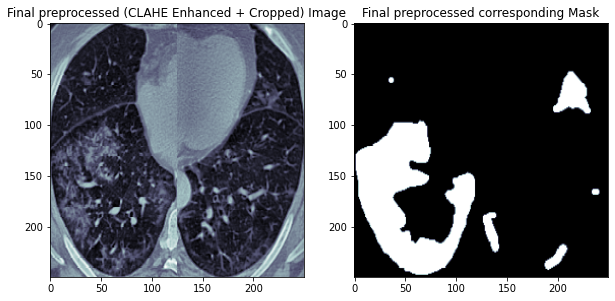

In [0]:
x = 60

rcParams['figure.figsize'] = 10,10

plt.subplot(1, 2, 1)
plt.imshow(cts[x], cmap='bone')
plt.title("Final preprocessed (CLAHE Enhanced + Cropped) Image")

plt.subplot(1, 2, 2)
plt.imshow(infections[x], cmap='bone')
plt.title("Final preprocessed corresponding Mask")

print(cts[x].shape, infections[x].shape)

* Also, figuring out that 498 slices were of complete black masks i.e. no infection. For right now, kept out as didn't want to bother the segmentation model with this. 
* A better approach would be to make a sub-task and use that sub-task's output as input in our main task. Train a separate binary classifier to classify the CT scan as complete black or not, then the not ones to be passed from the segmentation model trained in this notebook.

In [0]:
no_masks = []
for i in range(0, len(infections)):
  if np.unique(infections[i]).size == 1:
    no_masks.append(i)
print("Number of complete black masks :" , len(no_masks))

for index in sorted(no_masks, reverse = True):  
    del infections[index]  
    del cts[index]

Number of complete black masks : 497


* Following is the demo for the CLAHE enhanced images with histograms.
* Notice how the seahorse shaped infection in the left lung can be distinguised clearly after enhancement.

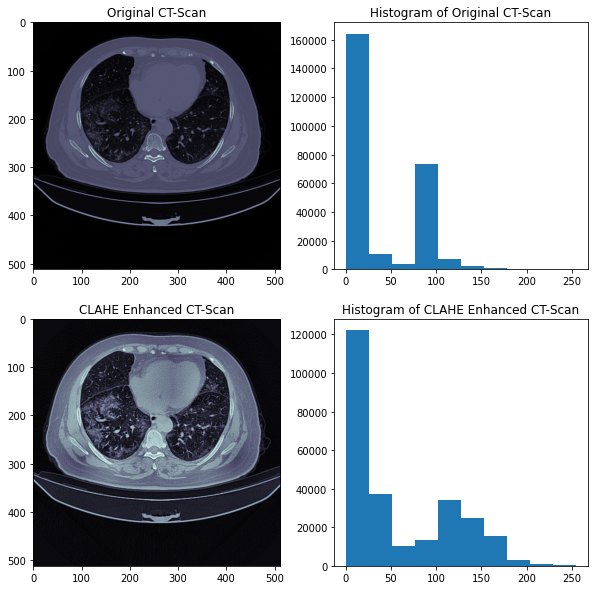

In [0]:
test_file = []
read_nii_demo(raw_data.loc[0,'ct_scan'], test_file)
test_file = np.array(test_file)
rcParams['figure.figsize'] = 10, 10
clahe_image = clahe_enhancer(test_file[60], demo = 1)

* A demo for the cropped images, notice how the unwanted part including the diaphragm got cut

In [0]:
# fig = plt.figure()
# rcParams['figure.figsize'] = 35, 35

# cropped_image, points1, points2 = cropper(test_file[120], demo = 1)
# #print(ret)
# print(points1, points2)

In [0]:
# test_mask = []
# read_nii_demo(raw_data.loc[0,'infection_mask'], test_mask)
# test_mask = np.array(test_mask)
# test_mask = np.uint8(test_mask*255)
# rcParams['figure.figsize'] = 10,10
# plt.imshow(test_mask[120][20:155, 4:217], cmap = 'bone')
# test_mask[120][20:155, 4:217].shape

* Finally 1614 samples which will later be split into train and test

In [0]:
print(len(cts) , len(infections))

1615 1615


* Also, since we copped the images and masks, all cannot be of same size, so again a dimension needs to be decided to which all could be resized to. 
* Used median of the all width and height but couldn't fit the RAM so reduced the size to 224, though images with larger resolution with more clear features will possibly give better results on the same model.

In [0]:
dim1=[]
dim2=[]
for i in range(0, len(cts)):
  dim1.append(cts[i].shape[0])
  dim2.append(cts[i].shape[1])
dim1 = np.array(dim1)
dim2 = np.array(dim2)

print("An idea about the new net dimension to which all must be resized to (some will increase and some decrease) --->", np.median(dim1),'x', np.median(dim2))

An idea about the new net dimension to which all must be resized to (some will increase and some decrease) ---> 250.0 x 250.0


In [0]:
# 32*11 = 352

In [0]:
new_dim = 224

In [0]:
for i in range(0,len(cts)):
  cts[i] = cv2.resize(cts[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # cts[i] = cts[i]/255
  infections[i] = cv2.resize(infections[i], dsize=(new_dim, new_dim), interpolation=cv2.INTER_LINEAR)
  # infections[i] = infections[i]/255

In [0]:
# for i in range(0, len(cts)):
#   cts[i] = cv2.cvtColor(cts[i], cv2.COLOR_GRAY2RGB)
# for i in range(0, len(infections)):
#   infections[i] = cv2.cvtColor(infections[i], cv2.COLOR_GRAY2RGB)

In [0]:
cts = np.array(cts)
infections = np.array(infections)

* Saving the numpy arrays to later reuse the same preprocessing for other models rather than doing it again and again.

In [0]:
# cts = cts.reshape( len(cts), new_dim, new_dim)
# infections = infections.reshape( len(infections), new_dim, new_dim)

In [0]:
cts = np.uint8(cts)
infections = np.uint8(infections)

In [0]:
# No Augmentation added this time

* Data augmentation pipeline

In [0]:
!pip install imgaug

In [0]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of all images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-40, 40), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            # mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
], random_order=True)

In [0]:
no_of_aug_imgs = 200
random_indices = np.random.randint(0, cts.shape[0], size=no_of_aug_imgs)
sample_cts = cts[random_indices]
sample_inf = infections[random_indices]

In [0]:
# sample_cts = np.floor(sample_cts)
# sample_inf = np.floor(sample_inf)
# sample_cts = np.uint64(sample_cts)
# sample_inf = np.uint64(sample_inf)

In [0]:
cts_aug, infections_aug = seq(images=sample_cts, 
                              segmentation_maps=sample_inf)

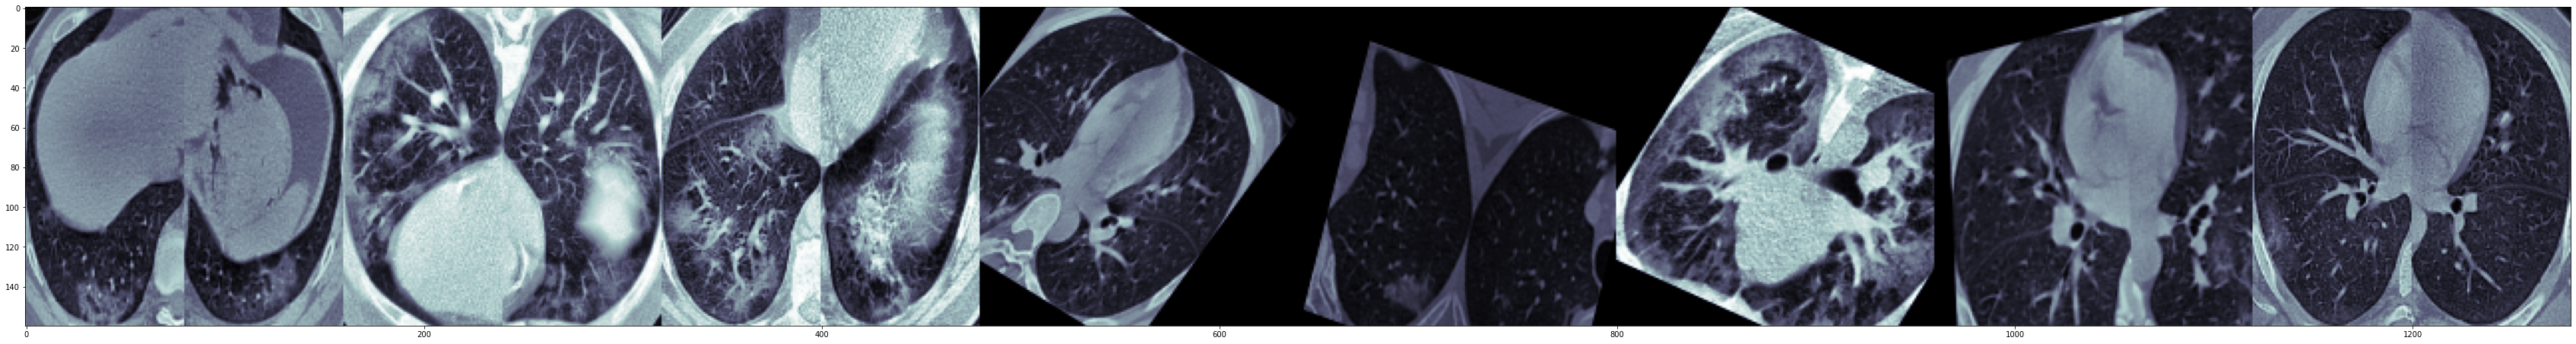

In [0]:
rcParams['figure.figsize'] = 60,60
rand = np.random.randint(0, no_of_aug_imgs, size=8)

cells1 = cts_aug[rand]
grid_image1 = np.hstack(cells1)
plt.imshow(grid_image1, cmap = 'bone')

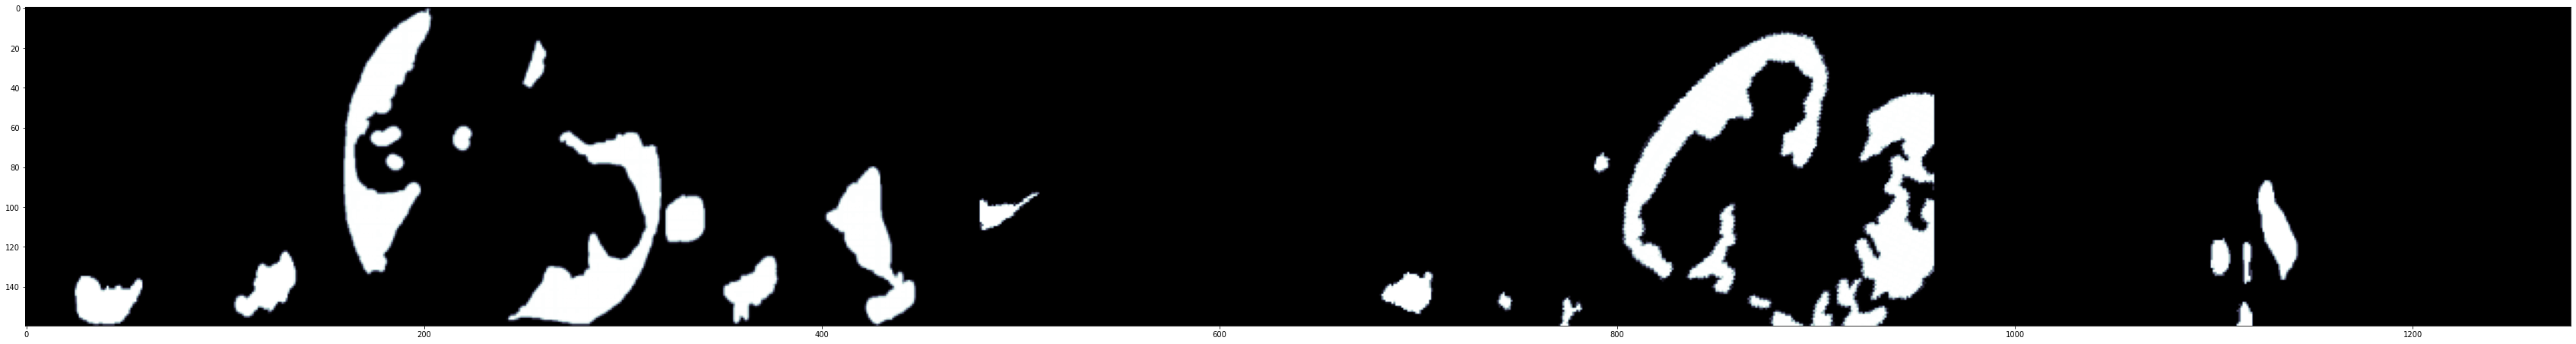

In [0]:
cells2 = infections_aug[rand]
grid_image2 = np.hstack(cells2)
plt.imshow(grid_image2, cmap = 'bone')

In [0]:
print(cts_aug.shape, infections_aug.shape)

(200, 160, 160) (200, 160, 160)


In [0]:
# cts = np.concatenate((cts, cts_aug), axis=0)
# infections = np.concatenate((infections, infections_aug), axis = 0)
# np.random.shuffle(cts)
# np.random.shuffle(infections)
# print(cts.shape, infections.shape)

In [0]:
cts_aug = cts_aug/255
infections_aug = infections_aug/255
cts_aug = cts_aug.reshape(len(cts_aug), new_dim, new_dim, 1)
infections_aug = infections_aug.reshape(len(infections_aug), new_dim, new_dim, 1)

* Normalizing images and masks from 0 to 1

In [0]:
joblib.dump(cts, 'cts_cropped_lungs_224.pkl')

['cts_cropped_lungs_224.pkl']

In [1]:
files.download('cts_cropped_lungs_224.pkl')

In [0]:
import joblib
joblib.dump(infections, 'infections_cropped_lungs_224.pkl')

['infections_cropped_lungs_224.pkl']

In [2]:
files.download('infections_cropped_lungs_224.pkl')

In [0]:
# temp = joblib.load('infections_cropped_lungs_224.pkl')

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cts = joblib.load('/content/drive/My Drive/cts and infections/cts_cropped_lungs_224.pkl')
infections = joblib.load('/content/drive/My Drive/cts and infections/infections_cropped_lungs_224.pkl')
print(cts.shape, infections.shape)

(1615, 224, 224) (1615, 224, 224)


In [0]:
cts = cts/255
infections = infections/255

In [0]:
cts = cts.reshape(len(cts), new_dim, new_dim, 1)
infections = infections.reshape(len(infections), new_dim, new_dim, 1)

In [0]:
# cts_new = []
# # lungs_infections_new = []
# infections_new = []

In [0]:
# for i in range(0, 2112):
#   cts_new.append(np.array(cts[i]))
#   # lungs_infections_new.append(np.array(lungs_infections[i]))
#   infections_new.append(np.array(infections[i]))

In [0]:
# cts_new = np.array(cts_new)
# # lungs_infections_new = np.array(lungs_infections_new)
# infections_new = np.array(infections_new)

* Just overlaying infection masks over the corresponding CT scans

In [0]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(10,30))

    plt.subplot(1,2,1)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image')

    # plt.subplot(1,2,2)
    # plt.imshow(array_list[0], cmap='bone')
    # plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    # plt.title('Lung Mask')

    plt.subplot(1,2,2)
    plt.imshow(array_list[0].reshape(new_dim, new_dim), cmap='bone')
    plt.imshow(array_list[1].reshape(new_dim, new_dim), alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    # plt.subplot(1,2,2)
    # plt.imshow(array_list[0].reshape(img_size,img_size), cmap='bone')
    # plt.imshow(array_list[1].reshape(img_size, img_size), alpha=0.5, cmap=color_map)
    # plt.title('Lung and Infection Mask')

#     plt.subplot(1,4,4)
#     plt.imshow(array_list[0], cmap='bone')
#     plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
#     plt.title('Lung and Infection Mask')

    plt.show()

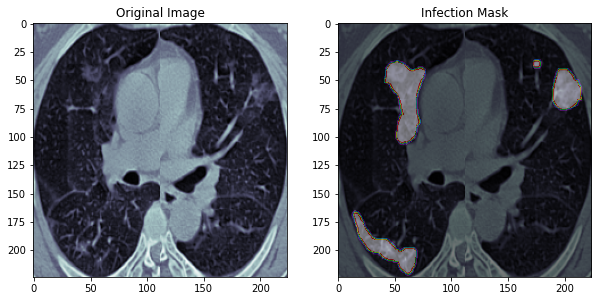

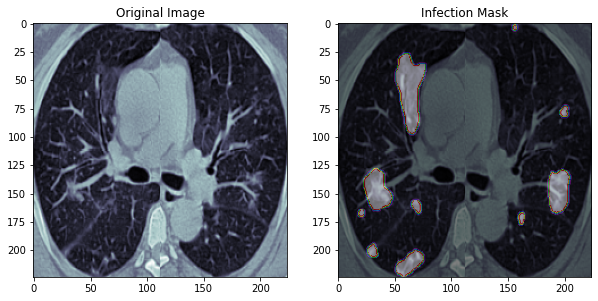

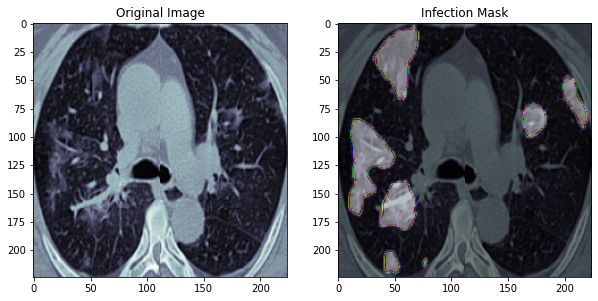

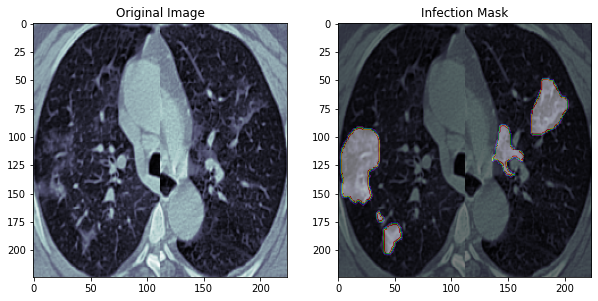

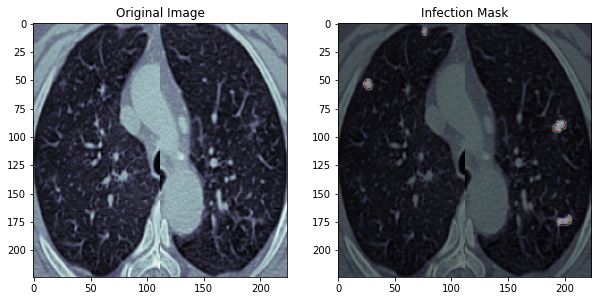

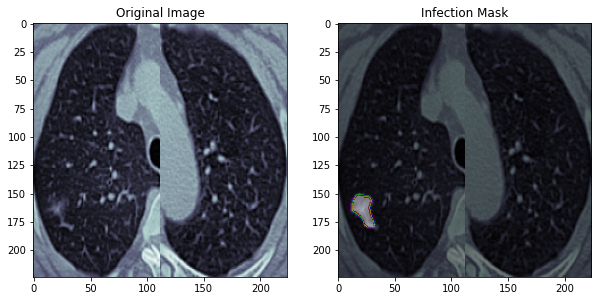

In [0]:
for index in [100,110,120,130,140,150]:
    plot_sample([cts[index], infections[index]])

In [0]:
from keras.losses import binary_crossentropy

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

In [0]:
# import math
# def step_decay(epoch):
#     initial_lrate = 0.0008
#     drop = 0.8
#     epochs_drop = 10
#     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#     print('New learning rate', lrate)
#     return lrate

# lrate = LearningRateScheduler(step_decay)

In [0]:
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=1):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        print('\nEpoch %05d: CosineAnnealingScheduler setting learning ''rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [0]:
cosine_annealer = CosineAnnealingScheduler(T_max=7, eta_max=0.0005, eta_min=0.0001)

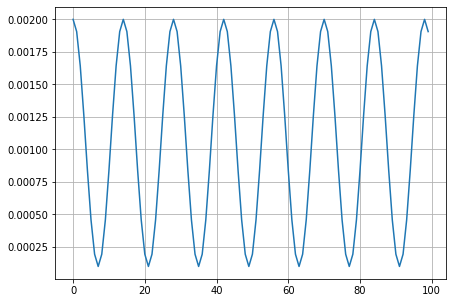

In [0]:
plt.grid('True')
rcParams['figure.figsize'] = 5,5
T_max=7
eta_max=0.002
eta_min = 0.0001
lr=[]
for epoch in range(100):    
    lr.append(eta_min + (eta_max - eta_min) * (1 + math.cos(math.pi * epoch / T_max)) / 2)
lr = np.array(lr)
plt.plot(lr)

In [0]:
inputs = Input((new_dim, new_dim, 1))
# s = Lambda(lambda x: x / 255) (inputs)

# def mish(inputs):
#     return inputs * tf.math.tanh(tf.math.softplus(inputs))
    
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (inputs)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.25)(p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.25)(p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(0.25)(p3)

c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(0.25)(p4)

c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (p4)
c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
u6 = BatchNormalization()(u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c6)


u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = BatchNormalization()(u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c7)


u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = BatchNormalization()(u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c8)


u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = BatchNormalization()(u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (u9)
c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal") (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
batch_size = 32
epochs = 80
#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=7, verbose=1)
filepath_dice_coeff_1="unet_covid_fold1.hdf5"
filepath_dice_coeff_2="unet_covid_fold2.hdf5"
filepath_dice_coeff_3="unet_covid_fold3.hdf5"
filepath_dice_coeff_4="unet_covid_fold4.hdf5"

checkpoint_dice_1 = ModelCheckpoint(filepath_dice_coeff_1, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint_dice_2 = ModelCheckpoint(filepath_dice_coeff_2, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint_dice_3 = ModelCheckpoint(filepath_dice_coeff_3, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')
checkpoint_dice_4 = ModelCheckpoint(filepath_dice_coeff_4, monitor='val_dice_coeff', verbose=1, save_best_only=True, mode='max')

# checkpoint_loss = ModelCheckpoint(filepath_loss, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [1]:
start = timeit.default_timer()

kf = KFold(n_splits=4, random_state=42, shuffle=True)

fold_number = 1

for train_index, test_index in kf.split(cts):

  print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
  print("Current fold number going:", fold_number)
  print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

  x_train, x_valid = cts[train_index], cts[test_index]
  y_train, y_valid = infections[train_index], infections[test_index]
  print("Shapes:", x_train.shape, x_valid.shape)

  if fold_number == 1:
    model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])

    results_1 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice_1])
    
  if fold_number == 2:
    model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])

    results_2 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice_2])
    
  if fold_number == 3:
    model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])

    results_3 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice_3])
    
  if fold_number == 4:
    model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[dice_coeff])

    results_4 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_valid, y_valid),
                    callbacks = [checkpoint_dice_4])
    
    
  fold_number = fold_number + 1


stop = timeit.default_timer()

In [72]:
print('Time of 4-fold cross validation: ', stop - start) 

Time of 4-fold cross validation:  5237.494347662


In [0]:
model.save_weights(filepath_dice_coeff_1)
model.save_weights(filepath_dice_coeff_2)
model.save_weights(filepath_dice_coeff_3)
model.save_weights(filepath_dice_coeff_4)

In [0]:
files.download(filepath_dice_coeff_1)

In [0]:
files.download(filepath_dice_coeff_2)

In [0]:
files.download(filepath_dice_coeff_3)

In [0]:
files.download(filepath_dice_coeff_4)

In [44]:
os.listdir('drive/My Drive/cts and infections/cross_val_model_weights/')

['unet_covid_fold1.hdf5',
 'unet_covid_fold2.hdf5',
 'unet_covid_fold4.hdf5',
 'unet_covid_fold3.hdf5']

In [0]:
model.load_weights('drive/My Drive/cts and infections/cross_val_model_weights/unet_covid_fold2.hdf5')

In [0]:
# x_train = np.concatenate((x_train, cts_aug), axis=0)
# y_train = np.concatenate((y_train, infections_aug), axis = 0)
# print(x_train.shape, y_train.shape)

* Loss functions and metrics

* All the hyperparameters are put in place after repeating trial and error for a fixed number of epochs.

* Some callbacks (model checkpointing with least validation loss, highest validation dice coefficient, learning rate reduction after some patience number of epochs)
* Also experimented with exponential decaying learning rate but found ReduceLROnPlateau a bit effective in this case.

In [68]:
gc.collect()

5476

In [0]:
paths = [filepath_dice_coeff_1, filepath_dice_coeff_2, filepath_dice_coeff_3, filepath_dice_coeff_4]

In [50]:
kf.get_n_splits(cts)

4

In [55]:
split_number = 1
for train_index, test_index in kf.split(cts):


  print("......................................................................................................................")
  print("Current fold number going:", split_number)
  print("......................................................................................................................")
  x_train, x_valid = cts[train_index], cts[test_index]
  y_train, y_valid = infections[train_index], infections[test_index]
  model.load_weights(paths[split_number-1])
  score = model.evaluate(x_valid, y_valid, batch_size=32)
  print("test loss, test dice coefficient:", score)

  split_number = split_number + 1

......................................................................................................................
Current fold number going: 1
......................................................................................................................
404/404 [==============================] - 2s 4ms/step
test loss, test dice coefficient: [0.027615873124634864, 0.958696722984314]
......................................................................................................................
Current fold number going: 2
......................................................................................................................
404/404 [==============================] - 2s 4ms/step
test loss, test dice coefficient: [0.04541058639193525, 0.9336515665054321]
......................................................................................................................
Current fold number going: 3
........................................................

In [62]:
!pip install -U segmentation-models

In [102]:
split_number = 1
the_range = np.arange(0.30,0.80, 0.05)
print(len(the_range))

total_dices=[]
total_ious=[]
total_precisions=[]
total_recalls=[]

for train_index, test_index in kf.split(cts):

  dices_per_threshold = []
  ious_per_threshold = []
  precisions_per_threshold = []
  recalls_per_threshold = []

  print(".................................................................................................................................................")
  print("Current split number going:", split_number)
  print(".................................................................................................................................................")
  x_train, x_valid = cts[train_index], cts[test_index]
  y_train, y_valid = infections[train_index], infections[test_index]
  model.load_weights(paths[split_number-1])

  for t in the_range:

    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("Calculating for threshold:", t)
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

    model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[sm.metrics.FScore(threshold=t)])
    dices_per_threshold.append(model.evaluate(x_valid, y_valid, batch_size=32)[1])

    model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[sm.metrics.IOUScore(threshold=t)])
    ious_per_threshold.append(model.evaluate(x_valid, y_valid, batch_size=32)[1])

    model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[sm.metrics.Precision(threshold=t)])
    precisions_per_threshold.append(model.evaluate(x_valid, y_valid, batch_size=32)[1])
    
    model.compile(optimizer=Adam(lr = 0.0005), loss=bce_dice_loss, metrics=[sm.metrics.Recall(threshold=t)])
    recalls_per_threshold.append(model.evaluate(x_valid, y_valid, batch_size=32)[1])

  total_dices.append(dices_per_threshold)
  total_ious.append(ious_per_threshold)
  total_precisions.append(precisions_per_threshold)
  total_recalls.append(recalls_per_threshold)

  split_number = split_number + 1

10
.................................................................................................................................................
Current split number going: 1
.................................................................................................................................................
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Calculating for threshold: 0.3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
404/404 [==============================] - 2s 5ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Calculating for threshold: 0.35
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
404/404 [==============================] - 2s 5ms/step
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Calculating for threshold: 0.39999999999999997
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
404/404 [==

In [114]:
total_dices = np.array(total_dices)
total_dices = np.transpose(total_dices)
df_dices = pd.DataFrame(data=total_dices, index = the_range, columns = [1,2,3,4])
print("4-fold Dices dataframe")
print("Rows indices: Thresholds, Column indices: Split Number")
df_dices

4-fold Dices dataframe
Rows indices: Thresholds, Column indices: Split Number


1         2         3         4
0.30  0.963419  0.936073  0.957263  0.964015
0.35  0.963255  0.937345  0.957698  0.963915
0.40  0.963084  0.938313  0.958026  0.963749
0.45  0.962879  0.939167  0.958283  0.963569
0.50  0.962611  0.939895  0.958504  0.963355
0.55  0.962332  0.940558  0.958677  0.963087
0.60  0.961976  0.941068  0.958752  0.962759
0.65  0.961552  0.941507  0.958773  0.962357
0.70  0.961034  0.941863  0.958670  0.961893
0.75  0.960329  0.942065  0.958426  0.961222

In [105]:
print("Maximum validation dice on any splits:", np.max(total_dices))
print("Maximum validation dice on each of the 4 splits (any threshold chosen):", np.array(df_dices.max(axis=0)))
print("Best threshold for each split", the_range[df_dices[1].argmax()], the_range[df_dices[2].argmax()], the_range[df_dices[3].argmax()], the_range[df_dices[4].argmax()])
print("Mean of all obtained dices:", df_dices.mean().mean())

Maximum validation dice on any splits: 0.9640153646469116
Maximum validation dice on each of the 4 splits (any threshold chosen): [0.96341884 0.94206512 0.95877349 0.96401536]
Best threshold for each split 0.3 0.7499999999999999 0.6499999999999999 0.3
Mean of all obtained dices: 0.9558329477906227


In [107]:
total_ious = np.array(total_ious)
total_ious = np.transpose(total_ious)
df_ious = pd.DataFrame(data=total_ious, index = the_range, columns = [1,2,3,4])
print("4-fold Ious dataframe")
print("Rows indices: Thresholds, Column indices: Split Number")
df_ious

4-fold Ious dataframe
Rows indices: Thresholds, Column indices: Split Number


1         2         3         4
0.30  0.929511  0.880076  0.918139  0.930600
0.35  0.929208  0.882319  0.918936  0.930415
0.40  0.928893  0.884031  0.919538  0.930106
0.45  0.928514  0.885544  0.920009  0.929774
0.50  0.928018  0.886837  0.920415  0.929376
0.55  0.927502  0.888016  0.920732  0.928880
0.60  0.926844  0.888922  0.920869  0.928273
0.65  0.926062  0.889706  0.920909  0.927528
0.70  0.925106  0.890342  0.920718  0.926671
0.75  0.923807  0.890706  0.920270  0.925431

In [108]:
print("Maximum validation iou on any splits:", np.max(total_ious))
print("Maximum validation iou on each of the 4 splits (any threshold chosen):", np.array(df_ious.max(axis=0)))
print("Best threshold for each split", the_range[df_ious[1].argmax()], the_range[df_ious[2].argmax()], the_range[df_ious[3].argmax()], the_range[df_ious[4].argmax()])
print("Mean of all obtained ious:", df_ious.mean().mean())

Maximum validation iou on any splits: 0.9306002259254456
Maximum validation iou on each of the 4 splits (any threshold chosen): [0.92951137 0.89070553 0.92090899 0.93060023]
Best threshold for each split 0.3 0.7499999999999999 0.6499999999999999 0.3
Mean of all obtained ious: 0.9156888499855995


In [117]:
total_precisions = np.array(total_precisions)
total_precisions = np.transpose(total_precisions)
df_precision = pd.DataFrame(data=total_precisions, index = the_range, columns = [1,2,3,4])
print("4-fold precision dataframe")
print("Rows indices: Thresholds, Column indices: Split Number")
df_precision

4-fold precision dataframe
Rows indices: Thresholds, Column indices: Split Number


1         2         3         4
0.30  0.964693  0.903388  0.942995  0.964459
0.35  0.966210  0.907630  0.945498  0.965964
0.40  0.967583  0.911340  0.947759  0.967270
0.45  0.968924  0.914864  0.949825  0.968605
0.50  0.970152  0.918214  0.951842  0.969832
0.55  0.971382  0.921530  0.953885  0.970993
0.60  0.972553  0.924812  0.955931  0.972143
0.65  0.973791  0.928214  0.957993  0.973368
0.70  0.975087  0.931837  0.960135  0.974697
0.75  0.976569  0.935720  0.962528  0.976204

In [120]:
print("Maximum validation precision on any splits:", np.max(total_precisions))
print("Maximum validation precision on each of the 4 splits (any threshold chosen):", np.array(df_precision.max(axis=0)))
print("Best threshold for each split", the_range[df_precision[1].argmax()], the_range[df_precision[2].argmax()], the_range[df_precision[3].argmax()], the_range[df_precision[4].argmax()])
print("Mean of all obtained precisions:", df_precision.mean().mean())

Maximum validation precision on any splits: 0.976569414138794
Maximum validation precision on each of the 4 splits (any threshold chosen): [0.97656941 0.93571979 0.96252799 0.97620362]
Best threshold for each split 0.7499999999999999 0.7499999999999999 0.7499999999999999 0.7499999999999999
Mean of all obtained precisions: 0.9534104615449905


In [121]:
total_recalls = np.array(total_recalls)
total_recalls = np.transpose(total_recalls)
df_recall = pd.DataFrame(data=total_recalls, index = the_range, columns = [1,2,3,4])
print("4-fold precision dataframe")
print("Rows indices: Thresholds, Column indices: Split Number")
df_recall

4-fold precision dataframe
Rows indices: Thresholds, Column indices: Split Number


1         2         3         4
0.30  0.962168  0.971277  0.972003  0.963594
0.35  0.960339  0.969127  0.970245  0.961899
0.40  0.958653  0.966978  0.968542  0.960278
0.45  0.956940  0.964835  0.966912  0.958614
0.50  0.955221  0.962657  0.965275  0.956993
0.55  0.953489  0.960418  0.963531  0.955341
0.60  0.951671  0.957933  0.961602  0.953591
0.65  0.949668  0.955213  0.959566  0.951632
0.70  0.947435  0.952136  0.957219  0.949466
0.75  0.944683  0.948529  0.954368  0.946746

In [122]:
print("Maximum validation recall on any splits:", np.max(total_recalls))
print("Maximum validation recall on each of the 4 splits (any threshold chosen):", np.array(df_recall.max(axis=0)))
print("Best threshold for each split", the_range[df_recall[1].argmax()], the_range[df_recall[2].argmax()], the_range[df_recall[3].argmax()], the_range[df_recall[4].argmax()])
print("Mean of all obtained recalls:", df_recall.mean().mean())

Maximum validation recall on any splits: 0.9720028638839722
Maximum validation recall on each of the 4 splits (any threshold chosen): [0.9621675  0.9712773  0.97200286 0.96359402]
Best threshold for each split 0.3 0.3 0.3 0.3
Mean of all obtained recalls: 0.95866968780756


In [0]:
plt.rcParams.update({'font.size': 22})
def compare_actual_and_predicted(image_no):

    fig = plt.figure(figsize=(50,50))

    plt.subplot(1,6,1)
    plt.imshow(cts[image_no].reshape(new_dim, new_dim), cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,6,2)
    plt.imshow(infections[image_no].reshape(new_dim,new_dim), cmap='bone')
    plt.title('Actual mask')

    plt.subplot(1,6,3)
    model.load_weights('drive/My Drive/cts and infections/cross_val_model_weights/unet_covid_fold1.hdf5')
    temp = model.predict(cts[image_no].reshape(1,new_dim, new_dim, 1))
    plt.imshow(temp.reshape(new_dim,new_dim), cmap='bone')
    plt.title('Model 1 output')

    plt.subplot(1,6,4)
    model.load_weights('drive/My Drive/cts and infections/cross_val_model_weights/unet_covid_fold2.hdf5')
    temp = model.predict(cts[image_no].reshape(1,new_dim, new_dim, 1))
    plt.imshow(temp.reshape(new_dim,new_dim), cmap='bone')
    plt.title('Model 2 output')

    plt.subplot(1,6,5)
    model.load_weights('drive/My Drive/cts and infections/cross_val_model_weights/unet_covid_fold3.hdf5')
    temp = model.predict(cts[image_no].reshape(1,new_dim, new_dim, 1))
    plt.imshow(temp.reshape(new_dim,new_dim), cmap='bone')
    plt.title('Model 3 output')

    plt.subplot(1,6,6)
    model.load_weights('drive/My Drive/cts and infections/cross_val_model_weights/unet_covid_fold4.hdf5')
    temp = model.predict(cts[image_no].reshape(1,new_dim, new_dim, 1))
    plt.imshow(temp.reshape(new_dim,new_dim), cmap='bone')
    plt.title('Model 4 output')

    plt.show()
    
# plt.imshow(temp.reshape(img_size, img_size), cmap = 'bone')
# plt.imshow(infections_scaled[120].reshape(img_size, img_size), cmap ='summer')

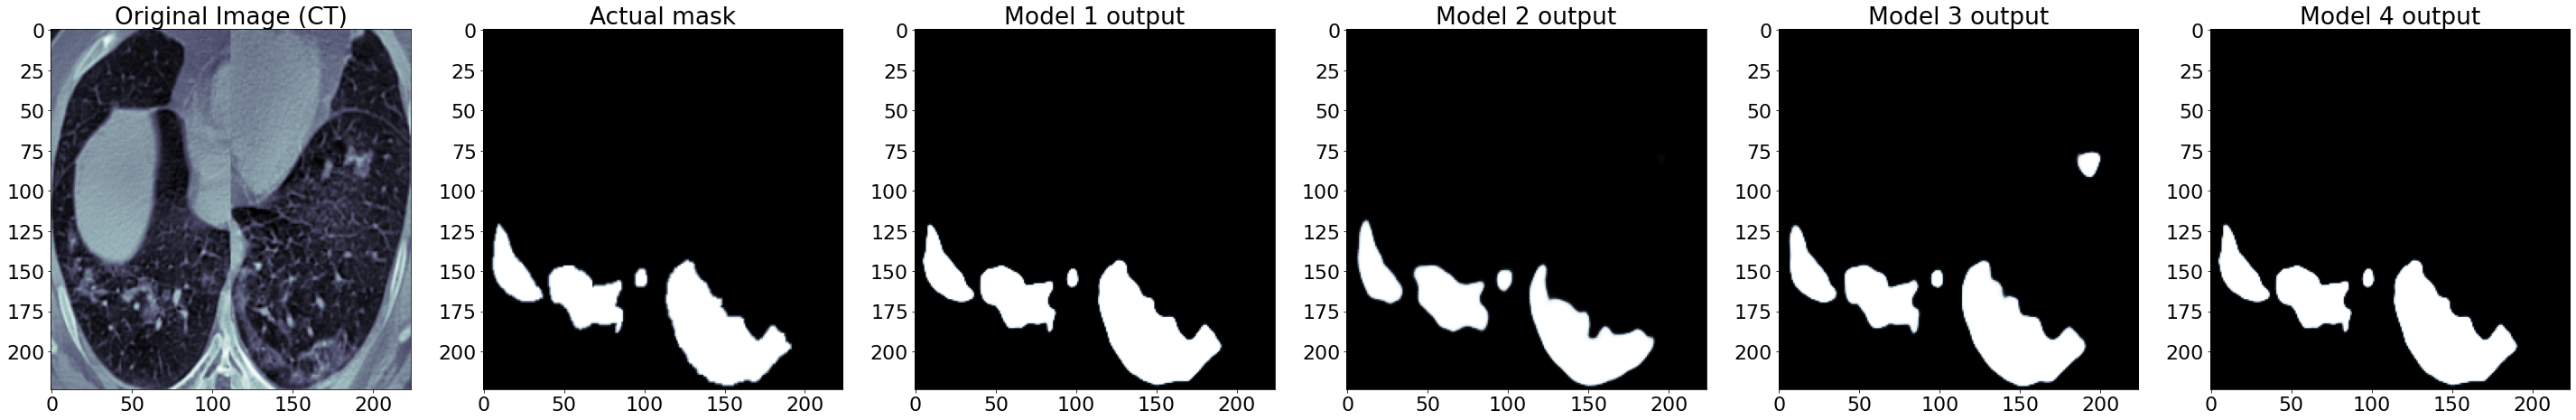

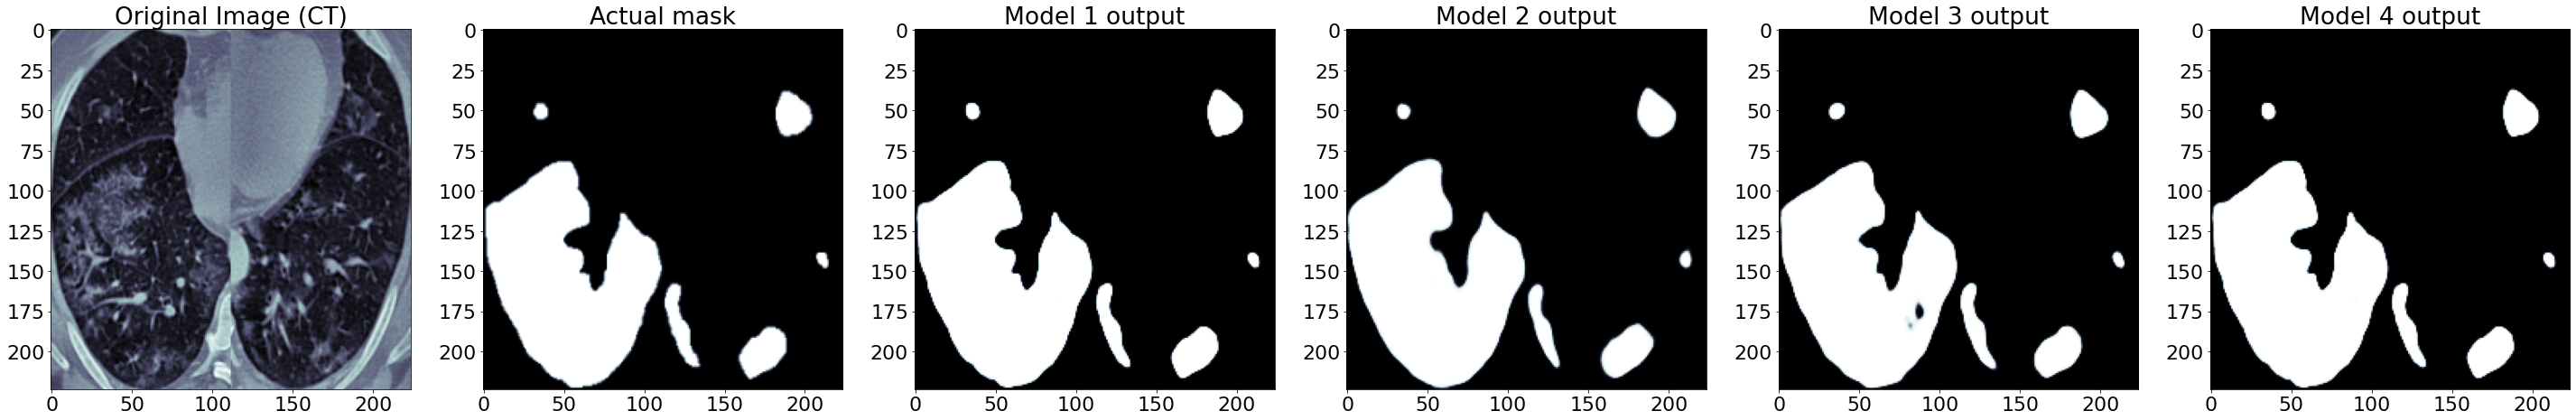

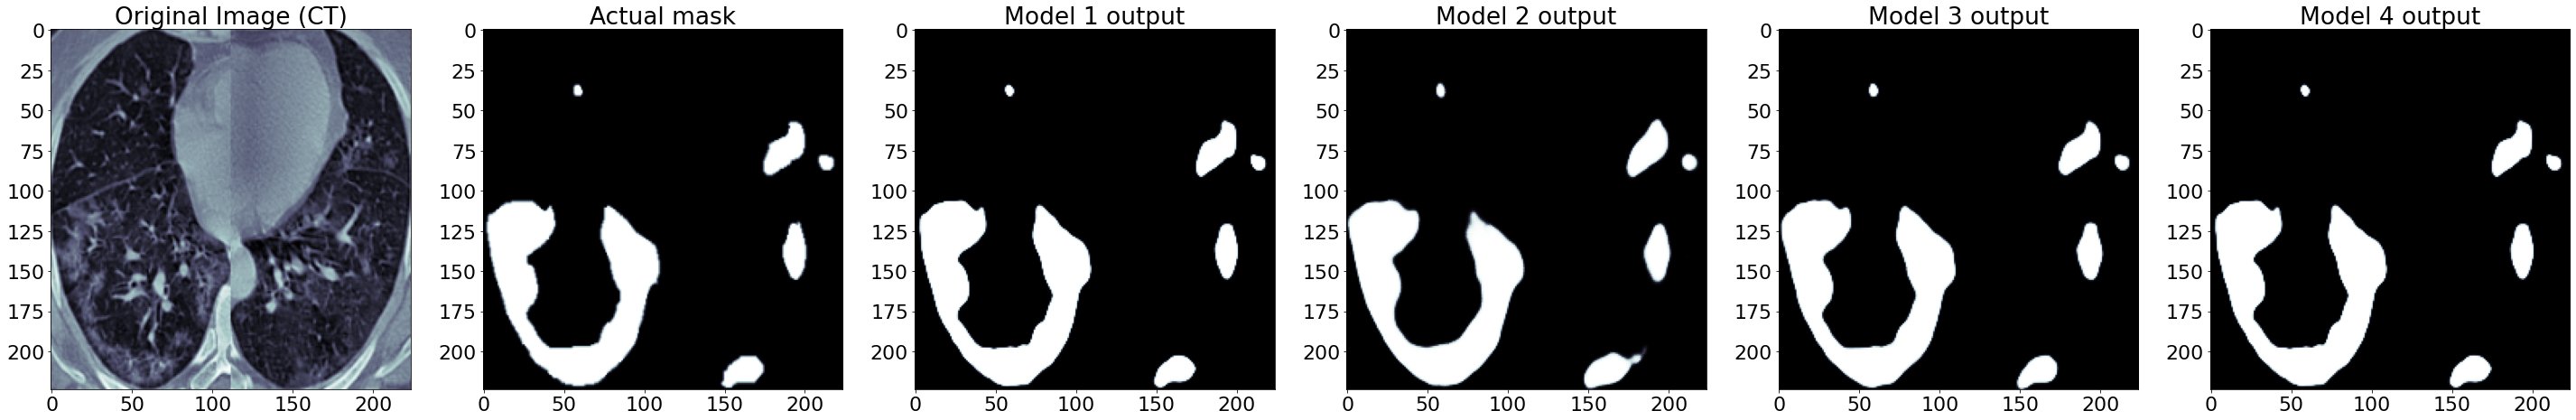

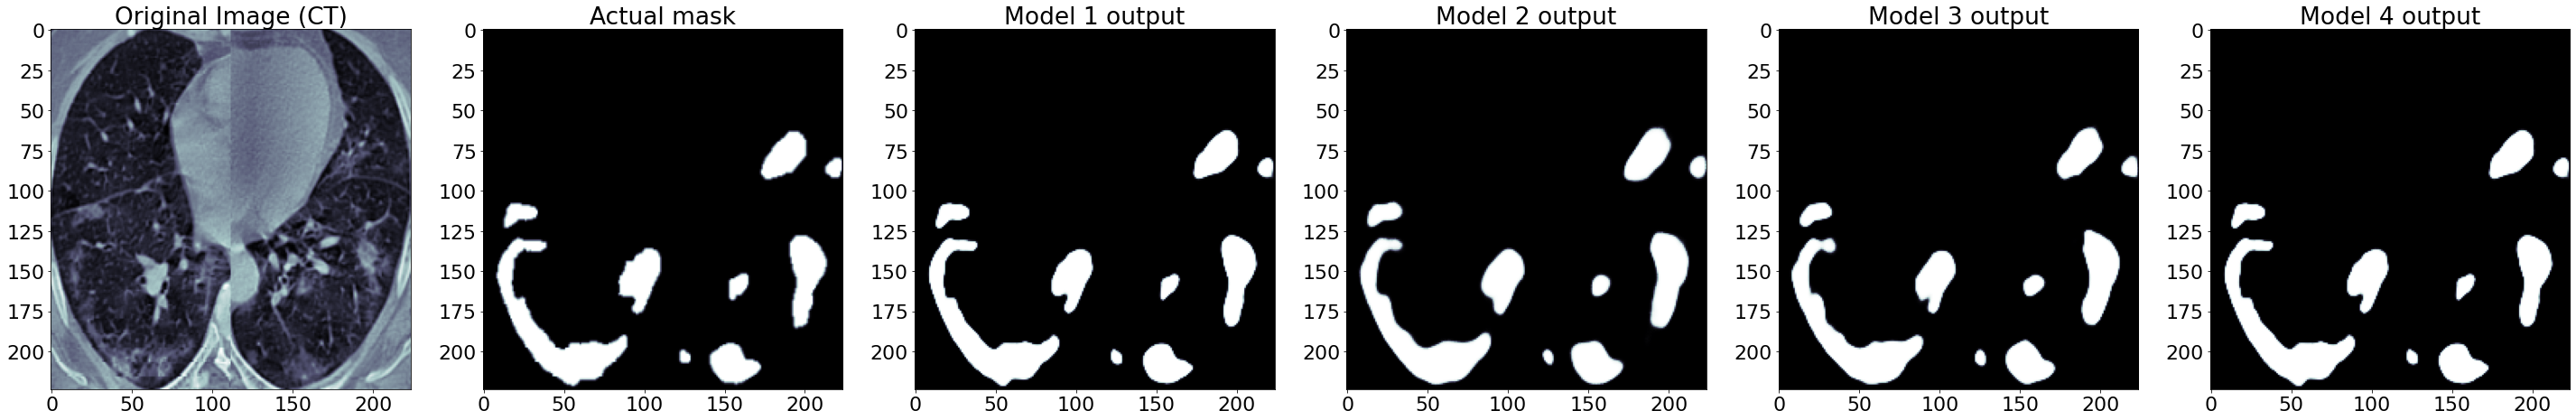

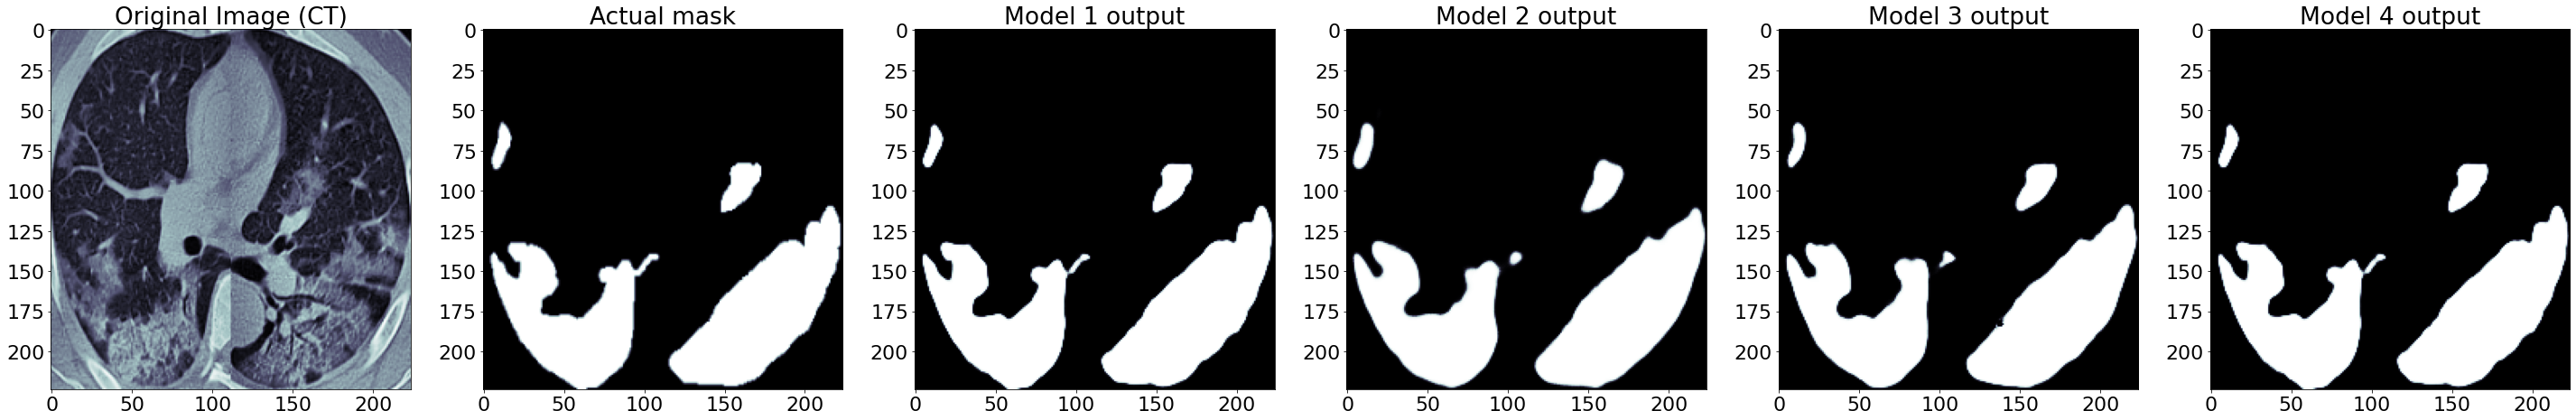

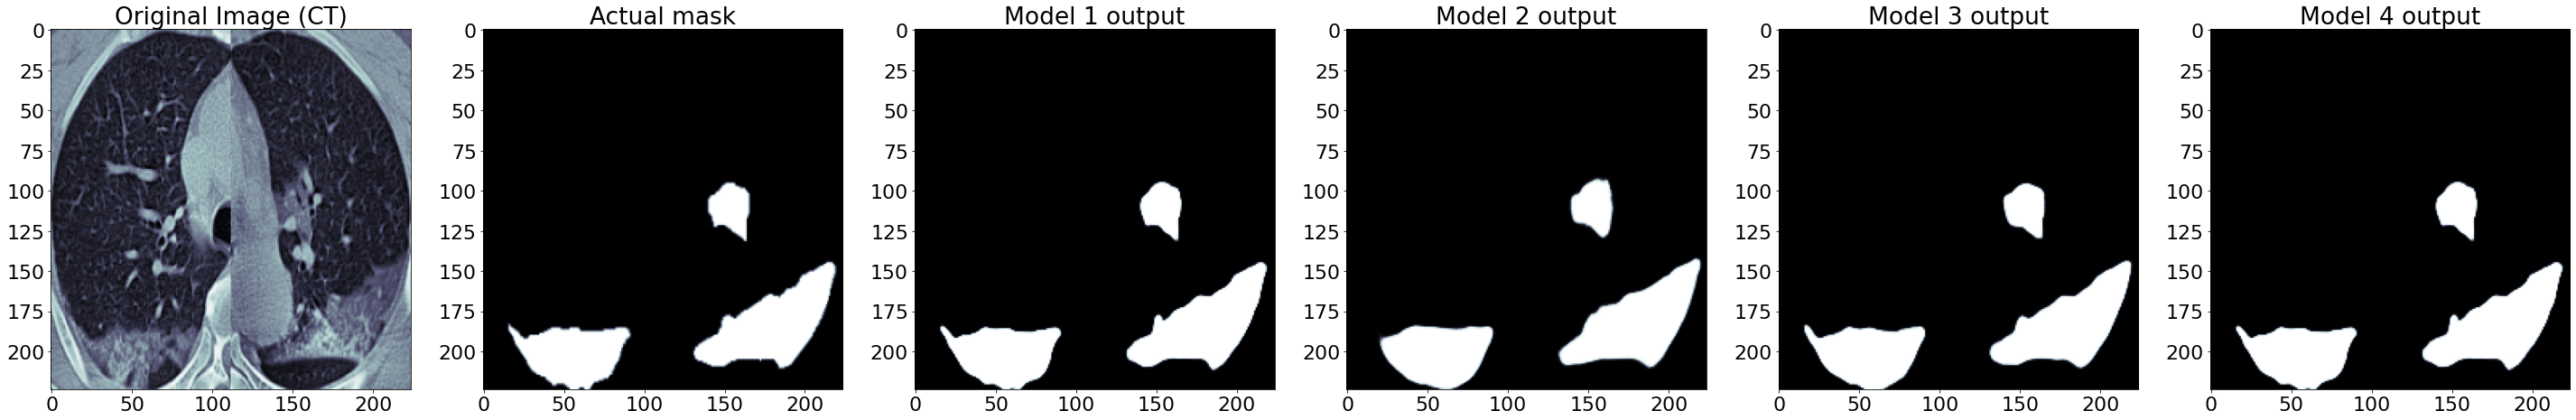

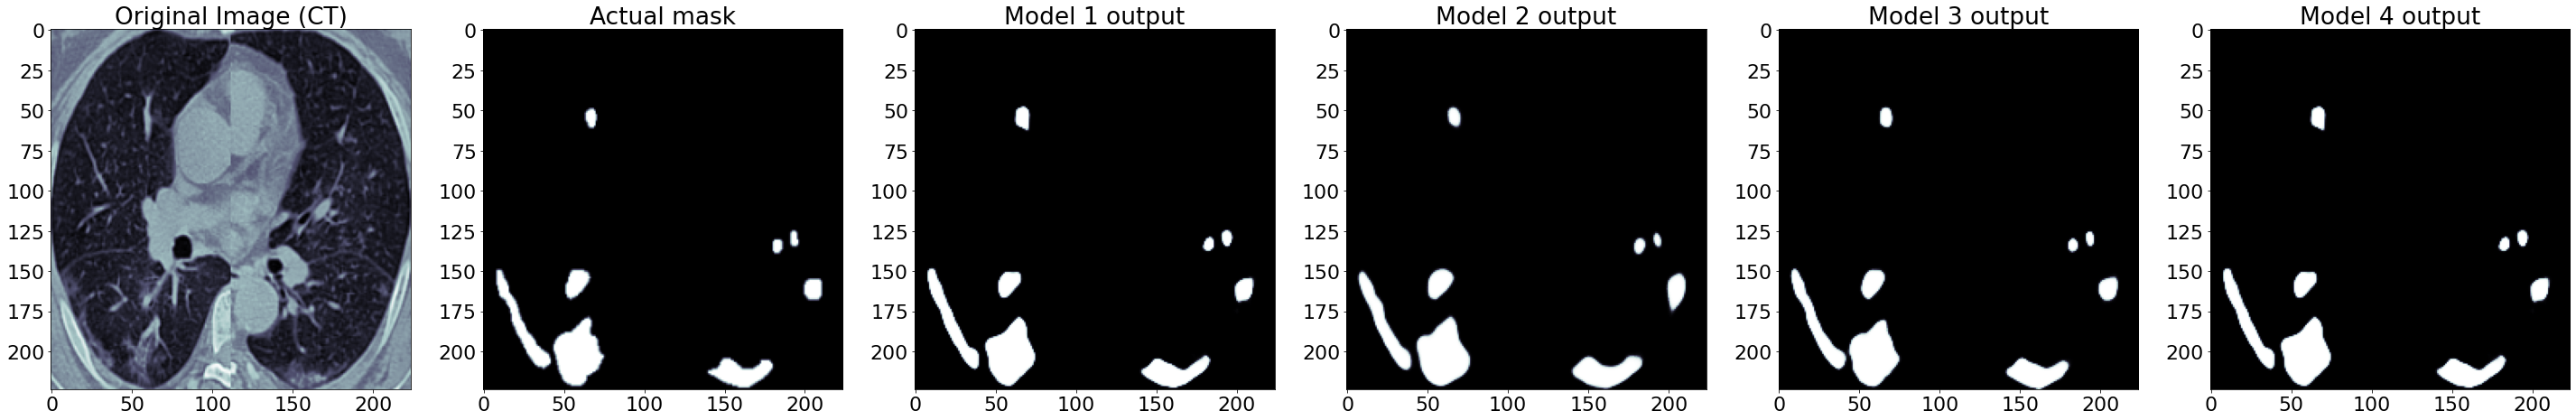

In [130]:
for i in [30,40,50,55, 355, 380, 90]:
    compare_actual_and_predicted(i)

In [0]:
gc.collect()

55312